# Next Day Low - Analytics

### Import Library

In [15]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [16]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [17]:
data = dataset.copy()

In [18]:
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Volume': 'sum'
    })
day_data.dropna(subset=['Close'], inplace=True)

In [19]:
TREND_WEAK = 1
TREND_NORMAL = 2
TREND_STRONG = 3
TREND_VERY_STRONG = 4
#
TREND_WEAK_LABEL = "Weak"
TREND_NORMAL_LABEL = "Normal"
TREND_STRONG_LABEL = "Strong"
TREND_VERY_STRONG_LABEL = "Very Strong"
#
TREND_WEAK_MAX = 25
TREND_NORMAL_MAX = 50
TREND_STRONG_MAX = 75
#
LENGTH_SHORT_ADX = 10
LENGTH_LONG_ADX = 45
#
LENGTH_ATR = 14
#
TODAY_IS_UP = 1
TODAY_IS_DOWN = -1
TODAY_NO_MOVE = 0
#
TODAY_IS_UP_LABEL = "Up"
TODAY_IS_DOWN_LABEL = "Down"
TODAY_NO_MOVE_LABEL = "No change"

In [20]:
def convertTrend(value):
    if np. isnan(value):
        trend_value = np.nan
    elif value < TREND_WEAK_MAX:
        trend_value = TREND_WEAK
    elif value < TREND_NORMAL_MAX:
        trend_value = TREND_NORMAL
    elif value < TREND_STRONG_MAX:
        trend_value = TREND_STRONG
    else:
        trend_value = TREND_VERY_STRONG

    return trend_value

def convertRSI(value):
    if np. isnan(value):
        rsi = np.nan
    elif value < 30:
        rsi = 20
    elif value < 50:
        rsi = 45
    elif value < 80:
        rsi = 65
    else:
        rsi = 80

    return rsi

def convertATR(value):
    if np. isnan(value):
        atr = np.nan
    elif value < 10:
        atr = 1
    elif value < 20:
        atr = 2
    elif value < 30:
        atr = 3
    elif value < 40:
        atr = 4
    else:
        atr = 5

    return atr

def convertUpDown(open, close):
    if close - open == 0:
        today_updown = TODAY_NO_MOVE
    elif close - open > 0:
        today_updown = TODAY_IS_UP
    else:
        today_updown = TODAY_IS_DOWN

    return today_updown

def calCandlestickRate(open, close, high, low):
    if high == low:
        return 0
    rate = abs(open - close) / (high - low)
    if rate < 0.25:
        simple_rate = 0
    elif rate < 0.5:
        simple_rate = 25
    elif rate < 0.75:
        simple_rate = 75
    else:
        simple_rate = 100

    return simple_rate

def prepareData(htd):
    htd['Next_Low'] = htd['Low'].shift(-1)
    htd['Next_Low_Is_Lower'] = htd.apply(
        lambda x: (1 if (x["Next_Low"] < x["Low"]) else 0), axis=1)

    short_adx = ta.adx(htd['High'], htd['Low'], htd['Close'], length=LENGTH_SHORT_ADX)

    htd["ADX_"+str(LENGTH_SHORT_ADX)] = short_adx["ADX_"+str(LENGTH_SHORT_ADX)]
    htd["short_trend"] = htd.apply(
        lambda row: convertTrend(row.loc["ADX_"+str(LENGTH_SHORT_ADX)]), axis=1
    )
    long_adx = ta.adx(htd['High'], htd['Low'], htd['Close'], length=LENGTH_LONG_ADX)
    htd["ADX_" + str(LENGTH_LONG_ADX)] = long_adx["ADX_" + str(LENGTH_LONG_ADX)]
    htd["long_trend"] = htd.apply(
        lambda row: convertTrend(row.loc["ADX_" + str(LENGTH_LONG_ADX)]), axis=1
    )

    htd["Today_Up_Down"] = htd.apply(
        lambda row: convertUpDown(row.loc["Open"], row.loc["Close"]), axis=1
    )
    htd['Yesterday_Up_Down'] = htd['Today_Up_Down'].shift(1)

    htd["Candlestick_Rate"] = htd.apply(
        lambda row: calCandlestickRate(row.loc["Open"], row.loc["Close"], row.loc["High"], row.loc["Low"]), axis=1
    )

    htd["EMA_5"] = ta.ema(htd["Close"], length=5)
    htd["EMA_20"] = ta.ema(htd["Close"], length=20)
    htd['MA5_above_MA20'] = htd.apply(
        lambda row: (1 if row['EMA_5'] >= row['EMA_20'] else 0), axis=1)
    htd["RSI_10"] = ta.rsi(htd["Close"], length=10)
    htd["RSI_10_Simple"] = htd.apply(
        lambda row: convertRSI(row.loc["RSI_10"]), axis=1
    )

    htd["ATR_" + str(LENGTH_ATR)] = ta.atr(htd['High'], htd['Low'], htd['Close'], length=LENGTH_ATR)
    htd["Volatility_ATR"] = htd.apply(
        lambda row: convertATR(row.loc["ATR_" + str(LENGTH_ATR)]), axis=1
    )

    return htd

In [21]:
day_data = prepareData(day_data)

In [22]:
day_data.dropna(inplace=True)

In [23]:
day_data

,Open,Close,High,Low,Volume,Next_Low,Next_Low_Is_Lower,ADX_10,short_trend,ADX_45,...,Today_Up_Down,Yesterday_Up_Down,Candlestick_Rate,EMA_5,EMA_20,MA5_above_MA20,RSI_10,RSI_10_Simple,ATR_14,Volatility_ATR
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-18,893.0,894.6,894.6,883.8,122686,878.5,1,26.569087,2.0,22.519940,...,1,-1.0,0,904.789056,904.177229,1,41.879590,45.0,11.999776,2.0
2018-12-19,895.5,884.5,896.0,878.5,122924,876.2,1,27.048080,2.0,22.393039,...,-1,1.0,75,898.026038,902.303207,0,35.850729,45.0,12.393148,2.0
2018-12-20,877.2,878.5,885.2,876.2,80638,871.1,1,27.722250,2.0,22.296696,...,1,-1.0,0,891.517358,900.036235,0,32.739760,45.0,12.150495,2.0
2018-12-21,876.6,879.5,879.5,871.1,143153,874.7,0,28.860334,2.0,22.258491,...,1,1.0,25,887.511572,898.080403,0,33.803509,45.0,11.882309,2.0
2018-12-24,879.8,877.0,881.8,874.7,108772,855.4,1,29.346837,2.0,22.185393,...,-1,1.0,25,884.007715,896.072746,0,32.380958,45.0,11.540368,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-30,1341.6,1342.0,1342.7,1331.5,186935,1333.7,0,21.726947,1.0,10.094137,...,1,1.0,0,1340.184720,1345.125496,0,47.119299,45.0,12.828660,2.0
2024-10-31,1339.0,1343.5,1347.8,1333.7,202412,1326.6,1,19.789261,1.0,10.101780,...,1,1.0,25,1341.289813,1344.970687,0,48.461959,45.0,12.919470,2.0
2024-11-01,1340.4,1330.4,1340.4,1326.6,215622,1317.1,1,18.673224,1.0,10.056581,...,-1,1.0,75,1337.659875,1343.583002,0,38.882153,45.0,13.203793,2.0


In [ ]:
feature_cols = ["short_trend", "long_trend", "Today_Up_Down", "Candlestick_Rate", "MA5_above_MA20", "RSI_10_Simple"]

## Visualize

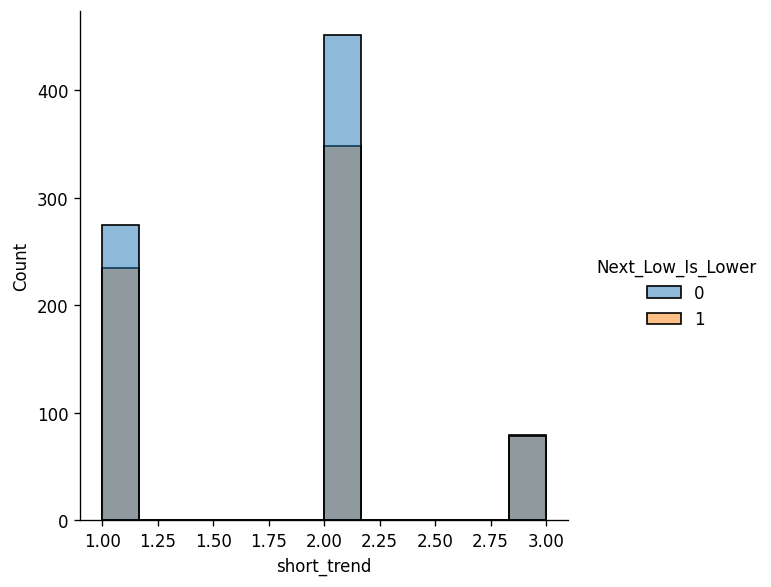

In [24]:
sns.displot(day_data, x="short_trend", hue="Next_Low_Is_Lower")

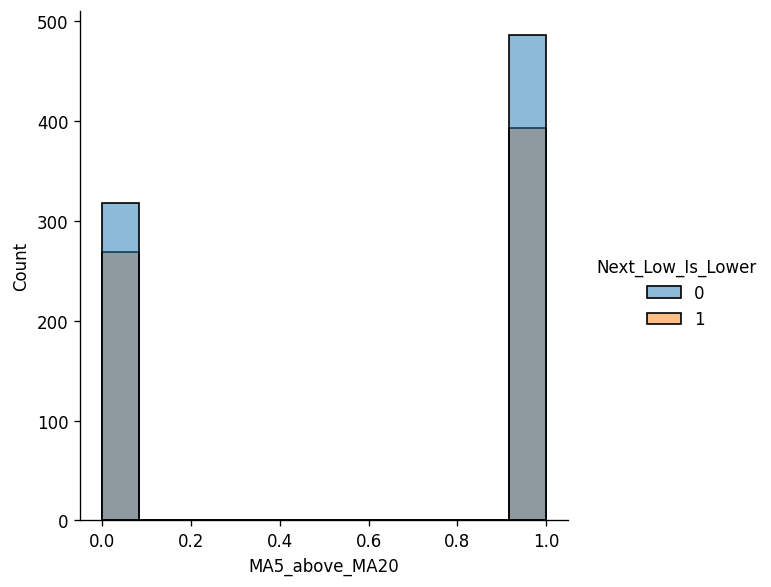

In [29]:
sns.displot(day_data, x="MA5_above_MA20", hue="Next_Low_Is_Lower")